In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
import numpy as np
import matplotlib.pylab as plt
import time
import fpfs

import sys
sys.path.append('/home/b7009348/FPFS-project/src')

import batsim.pltutil as batplot
from batsim.stamp import Stamp
from batsim.transforms import IaTransform, LensTransform

ModuleNotFoundError: No module named 'batsim.example_module'

[0.00136207 0.82404653]


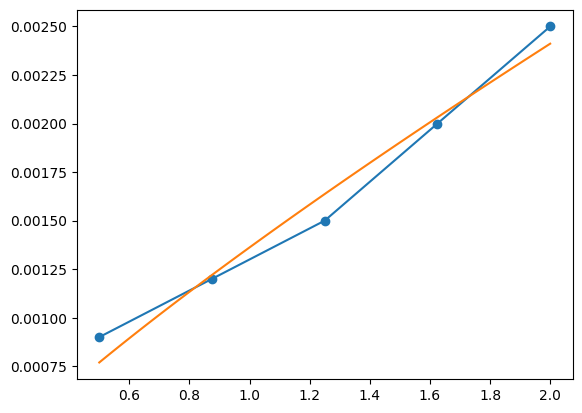

In [50]:
# fit curve to GAMA results in Georgieu 2019
from scipy.optimize import curve_fit

rwf = np.linspace(0.5,2.0,5)

A_IA = [0.0009, 0.0012, 0.0015, 0.002, 0.0025]

def power_law(rwf, m, b):
    return m * rwf**b

var, covs = curve_fit(power_law, rwf, A_IA)
print(var)
rwf_dense = np.linspace(0.5,2.0,100)
A_dense = var[0] * rwf_dense**var[1]

plt.plot(rwf, A_IA, marker='o')
plt.plot(rwf_dense, A_dense)

Text(0.5, 1.0, 'Preliminary')

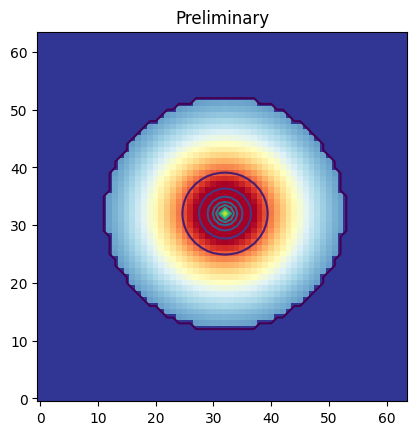

In [150]:
## create a galaxy with raidall dependent shear
flux = 40
scale = 0.2
nn = 64
hlr = 1.4

# create galaxy to be sampled by shear stamp objects
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux, trunc=4)

lensing = 0.02

# # # apply lensing shear to galaxy
stamp = Stamp(nn=nn, scale=scale, centering='fpfs')
lens = LensTransform(g1=lensing, g2=0, kappa=0)
stamp.transform_grids(lens)

# define ia shear as a % of lensing
ia = IaTransform(A1=-0.001, center=[0,0], scale=scale, hlr=hlr)
stamp.transform_grids(ia)

# get galaxy array from stamp object
gal_array = stamp.sample_galaxy(sersic_gal)
batplot.make_plot_image(gal_array)
plt.contour(gal_array, levels=15)
plt.title('Preliminary')

In [151]:
gal_array3 = stamp.sample_galaxy(sersic_gal)

# define sheared PSF
psf_array = np.zeros(stamp.shape)
psf_array[nn // 2, nn // 2] = 1

coords = np.array([nn//2, nn//2])
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.5f" % shear)

inner_shear = shear - lensing

2023/10/18 14:00:08 ---  Order of the shear estimator: nnord=4
2023/10/18 14:00:08 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 14:00:08 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


measured shear: 0.01925


In [152]:
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.5f" % shear)

outer_shear = shear - lensing

2023/10/18 14:00:08 ---  Order of the shear estimator: nnord=4
2023/10/18 14:00:08 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 14:00:08 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


measured shear: 0.01876


In [153]:
print('a =', inner_shear / outer_shear)

a = 0.602156170880129
